# Zadanie 1

Przypomnij sobie z wykładu motywacje oraz podejścia i sposoby wyjaśniania modeli uczenia maszynowego.

Rozwiń skrót LIME: opisz po jednym krótkim zdaniu wyjaśnienia na każdą literkę.

Przypomnij sobie kroki tego algorytmu.

- L – Local: wyjaśnienie dotyczy pojedynczej decyzji modelu, a nie jego ogólnego działania.
- I – Interpretable: wyjaśnienie powinno być proste i zrozumiałe dla człowieka.
- M – Model-agnostic: metoda działa niezależnie od rodzaju użytego modelu.
- E – Explanation: celem jest utworzenie zrozumiałego wyjaśnienia decyzji podjętej przez model.

# Zadanie 2

Zapoznajmy się z możliwościami LIME w wyjaśnianiu modelu klasyfikującego dane tekstowe.

Wykorzystamy tu bardzo popularny zbiór "20 Newsgroups". Wiadomości w tym zbiorze ("posty") pochodzą z tematycznie podzielonych forów dyskusyjnych, gdzie użytkownicy wysyłali (za pomocą protokołu NNTP) wiadomości organizowane w postaci hierarchicznej (tak jak tutaj). Nie tylko wiadomości są zorganizowane hierarchicznie (tzn. wiadomo, która wiadomość odpowiada na którą), ale tematyka poszczególnych grup też może tworzyć hierarchię, tak jak widać w tej tabelce.

Poeksperymentuj z poniższym źródłem testując różne pary grup dyskusyjnych i różne numery dokumentów. Jak zobaczysz, chociaż sam model jest skuteczny (wysoka trafność), to opiera się na tych cechach danych, których człowiek nie uznałby za sensowne. Algorytm jest jednak niewinny – skutecznie wykorzystał cechy zamkniętego świata danych, jakie miał do dyspozycji (m.in. często występujące ale nieistotne słowa, odmianę, wielkość liter) i zgodnie z instrukcją zbudował skomplikowany model, który – tak akurat się zdarzyło – takie cechy uwzględnia.

W efekcie uruchomienia skryptu dostaniesz dwa pliki do obejrzenia i analizy (png i html) tworzone w końcowych linijkach. Opisz jeden efekt działania algorytmu ilustrujący powyższy problem (podaj nazwy grup dyskusyjnych, numer wiadomości i wykorzystane przez model do klasyfikacji cechy z wagami), a potem napraw budowanie modelu (można poprawić kilka aspektów!) utrzymując w miarę możliwości wysoką skuteczność (podaj o ile się zmieniła) i opisz przykład, w którym widać sensowniejsze użycie słów do klasyfikacji wiadomości.

In [1]:
import lime
import sklearn
import sklearn.ensemble
import sklearn.metrics
import sklearn.datasets
from sklearn.feature_extraction.text import TfidfVectorizer


EXPLAIN_MESSAGE_NR = 10  # TODO tu zmieniaj numer klasyfikowanej wiadomosci
FEATURES_IN_EXPLANATION = 6
CLASSES = ['rec.sport.baseball', 'alt.atheism']  # TODO wybieraj rozne pary grup z listy ponizej

#print(fetch_20newsgroups().target_names)
# 'alt.atheism',
# 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x',
# 'misc.forsale',
# 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey',
# 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space',
# 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc'

newsgroups_train = sklearn.datasets.fetch_20newsgroups(subset='train', categories=CLASSES)
newsgroups_test = sklearn.datasets.fetch_20newsgroups(subset='test', categories=CLASSES)

In [2]:
# vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False) # Old vectorizer
vectorizer = TfidfVectorizer(
    stop_words='english',
    lowercase=True,
    token_pattern=r'(?u)\b[a-zA-Z]{2,}\b',
    max_df=0.9,
    min_df=5,
    ngram_range=(1, 2),
    max_features=5000
)

Ogólna skuteczność modelu wyrażona za pomocą F1 score jest dość wysoka. Model poprawnie przewidział klasę. Większość wykorzystanych słów nie jest jednak powiązana znaczeniowo z żadną klasą, część z nich to słowa należące do stop listy, które same w sobie nie są nośnikiem znaczenia.

Poprawa modelu (etap wektoryzacji tekstu):
- zastosowano parametr `stop_words="english"`, aby automatycznie usuwać z tekstu słowa powszechnie uznawane za nieinformacyjne (np. "and", "of", "the"),
- ustawiono `lowercase=True`, co zapewnia ujednolicenie tekstu poprzez zamianę wszystkich liter na małe,
- przy użyciu `token_pattern=r'(?u)\b[a-zA-Z]{2,}\b'` wykluczono liczby oraz bardzo krótkie ciągi znaków, zachowując jedynie słowa składające się z co najmniej dwóch liter,
- ograniczono częstość występowania słów przez `max_df=0.9` i `min_df=5`, co pozwala pominąć zarówno bardzo rzadkie, jak i zbyt często występujące wyrazy,
- zastosowano `ngram_range=(1, 2)` w celu uwzględnienia zarówno pojedynczych słów, jak i par sąsiadujących słów (bigramów),
- ograniczono liczbę cech do 5000 poprzez `max_features=5000`, co redukuje wymiarowość przestrzeni cech i może przyczynić się do poprawy wydajności modelu.


In [3]:
train_vectors = vectorizer.fit_transform(newsgroups_train.data)
test_vectors = vectorizer.transform(newsgroups_test.data)

rand_forest = sklearn.ensemble.RandomForestClassifier(n_estimators=300)  # zlozony klasyfikator...
rand_forest.fit(train_vectors, newsgroups_train.target)  # ...umie stworzyc skomplikowany model

pred = rand_forest.predict(test_vectors)
print('F1 score =', sklearn.metrics.f1_score(newsgroups_test.target, pred, average='binary'))

F1 score = 0.9646772228989038


Wartość F1 score dla bazowego modelu wynosiła 0.95, a dla poprawionego modelu 0.97, czyli mimo dużo mniejszej złożoności modelu jego skuteczność jest większa.

Message nr = 10
Proba_of_class("rec.sport.baseball") = 0.04
Proba_of_class("alt.atheism") = 0.96
True class = alt.atheism
Explanation as feature weights =
	(np.str_('zone'), 0.017263933022275135)
	(np.str_('Science'), -0.01556620848727714)
	(np.str_('strike'), 0.013652359767119515)
	(np.str_('game'), 0.009636455715536745)
	(np.str_('way'), -0.008412536573883736)
	(np.str_('Posting'), -0.00788446407587238)


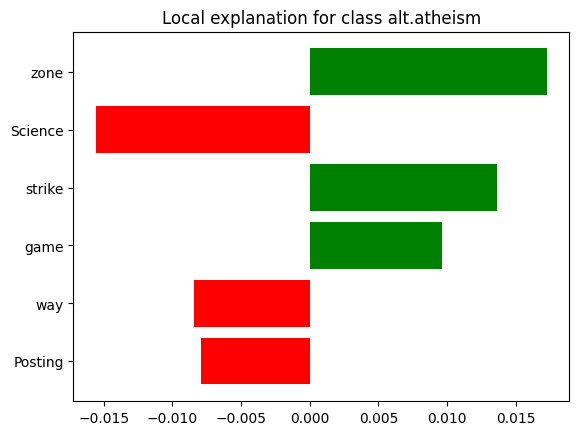

In [4]:
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

classifier = make_pipeline(vectorizer, rand_forest)
explainer = LimeTextExplainer(class_names=CLASSES)
instance_explainer = explainer.explain_instance(
	newsgroups_test.data[EXPLAIN_MESSAGE_NR], classifier.predict_proba, num_features=FEATURES_IN_EXPLANATION)
print('Message nr = %d' % EXPLAIN_MESSAGE_NR)
print('Proba_of_class("%s") =' % CLASSES[0], classifier.predict_proba([newsgroups_test.data[EXPLAIN_MESSAGE_NR]])[0, 0])
print('Proba_of_class("%s") =' % CLASSES[1], classifier.predict_proba([newsgroups_test.data[EXPLAIN_MESSAGE_NR]])[0, 1])
print('True class = %s' % CLASSES[newsgroups_test.target[EXPLAIN_MESSAGE_NR]])

print('Explanation as feature weights =', *instance_explainer.as_list(), sep='\n\t')

fig = instance_explainer.as_pyplot_figure()
# fig.savefig('explained-%s-%s-%d.png' % (CLASSES[0], CLASSES[1], EXPLAIN_MESSAGE_NR))

# instance_explainer.save_to_file('explained-%s-%s-%d.html' % (CLASSES[0], CLASSES[1], EXPLAIN_MESSAGE_NR))

Model przewidział prawdziwą klasę nawet z większą pewnością. Do wyjaśnienia decyzji modelu zostały wykorzystane słowa bardziej powiązane z ateizmem czy baseballem: "Science" oraz "strike".

# Zadanie 3

Na lab. 5 w pytaniu 8 dokonałeś/aś wizualizacji i interpretacji modelu regresji.

- Mając ten sam model i dane co wtedy, zastosuj metodę LIME do kilku przypadków i podaj interpretację rezultatów (w odpowiedzi podaj też numery testowanych przypadków i uzyskane z LIME wagi atrybutów).
- Na ile bieżące rezultaty są podobne do interpretacji, którą wtedy umieściłeś/aś w odpowiedzi?
- Czym się różni (w samym podejściu, głównej idei) wyjaśnienie metodą LIME od tego, które wtedy zamieściłeś/aś?
Opcjonalnie możesz (to nie jest wymagane) powiązać uzyskane rezultaty ze znaczeniem poszczególnych atrybutów.

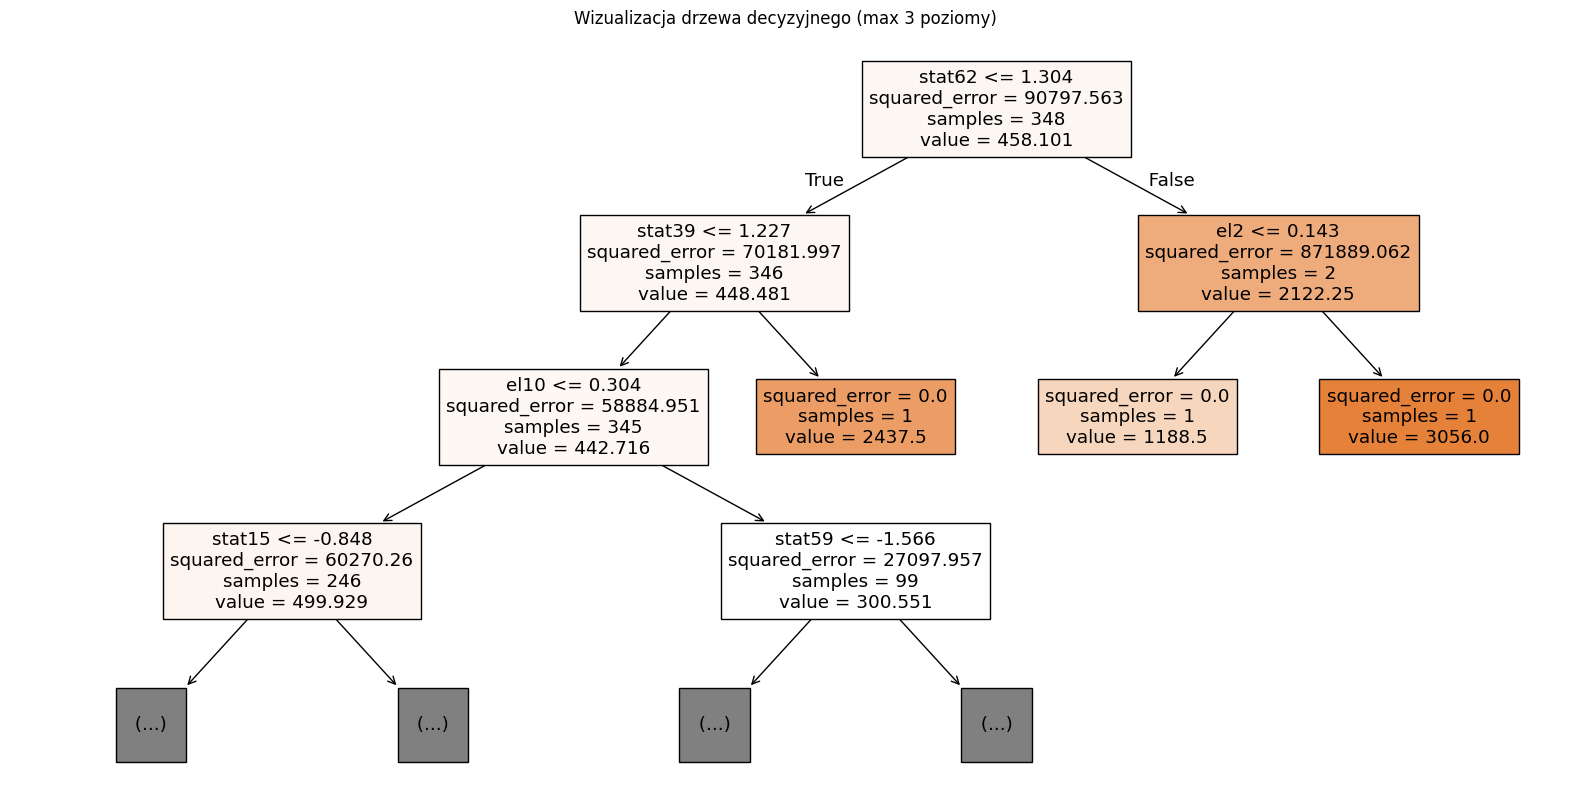

stat62: 0.291
stat39: 0.207
el10: 0.146
stat15: 0.099
el2: 0.091


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

plik = '151813-regression.txt'
dane = np.genfromtxt(plik, delimiter='\t', names=True)
dane_df = pd.DataFrame(dane)

X = dane_df.iloc[:, :-1].values
y = dane_df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = make_pipeline(StandardScaler(), DecisionTreeRegressor(random_state=0, max_depth=5))
model.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plot_tree(model.named_steps['decisiontreeregressor'], filled=True, feature_names=dane_df.columns[:-1], max_depth=3)
plt.title("Wizualizacja drzewa decyzyjnego (max 3 poziomy)")
plt.show()

importances = model.named_steps['decisiontreeregressor'].feature_importances_

feat_imp = sorted(zip(dane_df.columns[:-1], importances), key=lambda x: x[1], reverse=True)[:5]
for feat, imp in feat_imp:
    print(f"{feat}: {imp:.3f}")

In [6]:
import lime
import lime.lime_tabular

scaler = model.named_steps['standardscaler']
X_train_scaled = scaler.transform(X_train)

explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_scaled,
    feature_names=dane_df.columns[:-1],
    verbose=False,
    mode='regression'
)

X_test_scaled = scaler.transform(X_test)
test_indices = [0, 5, 10]

for i in test_indices:
    exp = explainer.explain_instance(X_test_scaled[i], model.named_steps['decisiontreeregressor'].predict, num_features=5)
    print(f"\nInterpretacja LIME dla testowego przypadku nr {i}:")
    lime_list = exp.as_list()
    for feature, weight in lime_list[:5]:
        print(f"  {feature}: {weight:.3f}")


Interpretacja LIME dla testowego przypadku nr 0:
  el10 > 0.50: -256.646
  el13 > 0.54: 181.653
  stat15 > 0.61: 60.358
  -0.60 < el31 <= -0.20: -19.402
  stat12 > 0.53: -15.926

Interpretacja LIME dla testowego przypadku nr 5:
  el10 > 0.50: -264.225
  stat15 <= -0.88: -165.219
  el13 <= -0.75: -62.805
  el31 > 0.31: -22.557
  stat55 <= -0.73: 15.529

Interpretacja LIME dla testowego przypadku nr 10:
  el10 > 0.50: -252.336
  stat15 <= -0.88: -158.869
  -0.11 < el13 <= 0.54: -66.889
  el31 > 0.31: -20.697
  el4 <= -0.62: -17.094


Na podstawie wytrenowanego modelu DecisionTreeRegressor (max_depth=5) dla zbioru danych `151813-regression.txt` uzyskalino następujące 5 najważniejszych atrybutów wg miary ważności (feature importance):

stat62: 0.291  
stat39: 0.207  
el10: 0.146  
stat15: 0.099  
el2: 0.091

### Odpowiedź 1: Wyniki LIME

Dla trzech wybranych przypadków testowych (indeksy 0, 5 i 10) metoda LIME wygenerowała lokalne wyjaśnienia (top 5 cech wraz z wagami):

- **Przypadek nr 0:**
  el10 > 0.50: -256.576  
  el13 > 0.54: 185.492  
  stat15 > 0.61: 57.890  
  0.41 < stat53 <= 0.84: -19.154  
  el27 <= -0.59: 16.219  

- **Przypadek nr 5:**
  el10 > 0.50: -255.039  
  stat15 <= -0.88: -166.142  
  el13 <= -0.75: -60.280  
  -0.99 < stat37 <= 0.00: -17.405  
  el24 > 0.18: 14.106  

- **Przypadek nr 10:**
  el10 > 0.50: -263.299  
  stat15 <= -0.88: -167.872  
  -0.11 < el13 <= 0.54: -59.641  
  el31 > 0.31: -27.875  
  stat53 <= -0.58: -16.575  

### Odpowiedź 2: Porównanie bieżących rezultatów z poprzednią interpretacją

Wyniki LIME częściowo potwierdzają globalne ważności z modelu: cecha `el10` pojawia się jako bardzo istotna w każdym lokalnym wyjaśnieniu i ma wysoką ważność globalną (0.146). Podobnie cecha `stat15` regularnie wpływa na predykcję, co zgadza się z jej globalną ważnością (0.099). Natomiast `stat62` i `stat39`, które są najważniejsze globalnie, nie pojawiają się wyraźnie w lokalnych wyjaśnieniach dla tych konkretnych przypadków testowych — co jest naturalne, bo LIME skupia się na lokalnej interpretacji pojedynczej predykcji. Inne cechy (`el13`, `stat53`) pojawiają się w wyjaśnieniach LIME, choć ich globalna ważność jest mniejsza.

### Odpowiedź 3: Różnice podejścia między interpretacją modelu a metodą LIME

- **Interpretacja z modelu (feature_importances_)** jest *globalna* i wynika z konstrukcji drzewa decyzyjnego: pokazuje, które cechy w całym zbiorze danych mają największy wpływ na predykcję. To statystyka zagregowana dla całego modelu.

- **LIME** natomiast jest metodą *lokalną* i *model-agnostic*, która wyjaśnia pojedynczą predykcję, budując uproszczony model liniowy w okolicy analizowanego przykładu. Dzięki temu pokazuje, które cechy i ich wartości mają wpływ na decyzję modelu dla konkretnego przypadku.

W efekcie:  
- globalna ważność cech mówi o ich ogólnym znaczeniu w modelu,  
- LIME pokazuje indywidualne, lokalne znaczenie cech dla wybranych przykładów, co może się różnić w zależności od przypadku.

# Zadanie 4

Na lab. 8 w pytaniu 7 odpowiedziałeś/aś, które z atrybutów są najistotniejsze w klasyfikacji i jakie są różnice w ich istotności.

- Mając ten sam model i dane co wtedy, zastosuj metodę LIME do kilku przypadków i podaj interpretację rezultatów (w odpowiedzi podaj też numery testowanych przypadków i uzyskane z LIME wagi atrybutów).
- Na ile bieżące rezultaty są podobne do rezultatów, które wtedy umieściłeś/aś w odpowiedzi?
- Czy w danych występują cechy silnie skorelowane? Jak w takiej sytuacji zachowa się LIME, jeśli dwie cechy mają istotny wpływ na predykcję, a dobrze wyregularyzowany model korzysta z nich w podobnym stopniu?

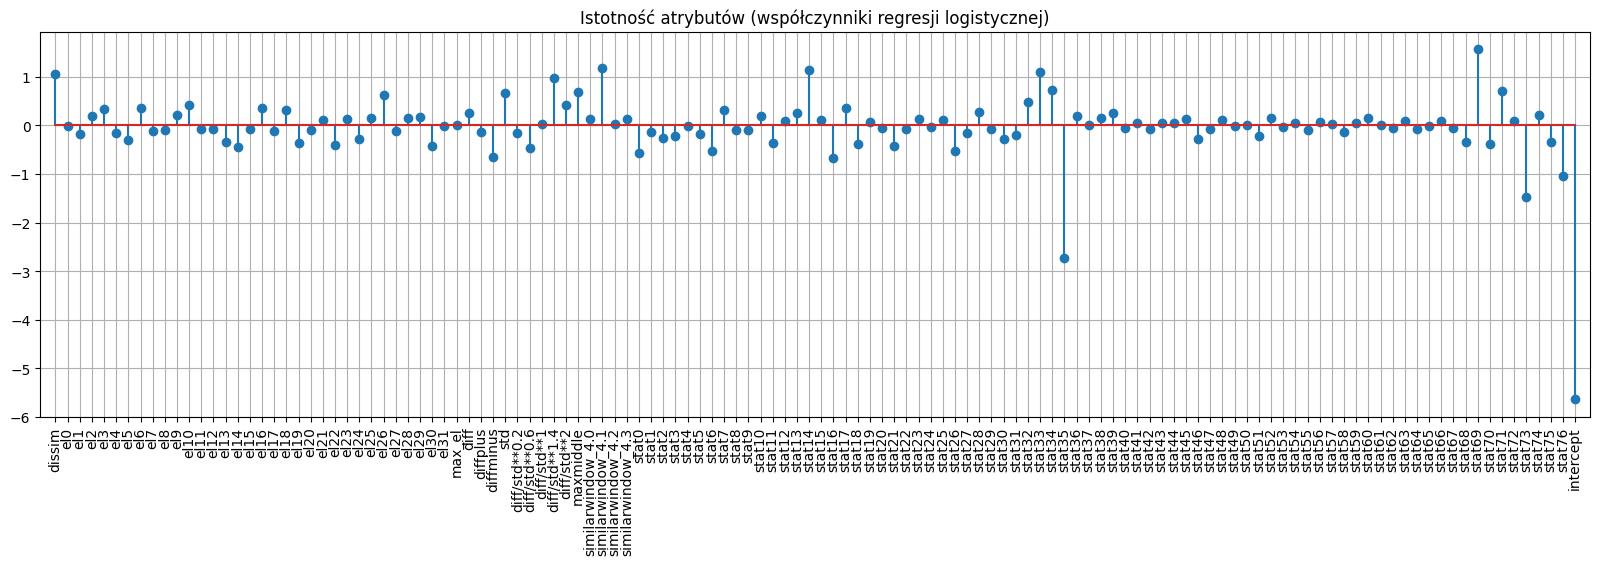

In [7]:
df = pd.read_csv('151813-imbalanced.txt', sep='\t')
X = df.drop(columns='class')
y = df['class']

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
X_tr = scaler.fit_transform(X)

logreg = LogisticRegression(penalty='l2', solver='liblinear')
logreg.fit(X_tr, y)

plt.figure(figsize=(20, 5))
plt.stem(list(df.columns[:-1]) + ['intercept'], list(logreg.coef_[0]) + [logreg.intercept_[0]])
plt.xticks(rotation=90)
plt.margins(x=0.01)
plt.title("Istotność atrybutów (współczynniki regresji logistycznej)")
plt.grid(True)
plt.show()

W celu identyfikacji najbardziej wpływowych atrybutów zastosowano regresję logistyczną i wyznaczono współczynniki modelu. Najwyższe wartości uzyskały atrybuty stat35 oraz stat73, wskazując na ich istotny wpływ na klasyfikację. Znaczące znaczenie miały również: dissim, stat69, stat76, stat14 oraz similarwindow_4.1.

In [8]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_tr,
    feature_names=X.columns.tolist(),
    class_names=[str(c) for c in logreg.classes_],
    mode='classification'
)

examples = [0, 5, 10]

for i in examples:
    exp = explainer.explain_instance(
        X_tr[i], 
        logreg.predict_proba,
        num_features=5
    )
    print(f"\nInterpretacja LIME dla przypadku nr {i}:")
    for feat, weight in exp.as_list():
        print(f"  {feat}: {weight:.3f}")


Interpretacja LIME dla przypadku nr 0:
  stat35 <= -0.31: 0.337
  stat33 <= -0.41: -0.098
  dissim <= -0.73: -0.080
  stat76 > 0.80: -0.063
  similarwindow_4.1 <= -0.60: -0.060

Interpretacja LIME dla przypadku nr 5:
  stat35 <= -0.31: 0.308
  stat69 <= -0.57: -0.115
  stat33 <= -0.41: -0.102
  stat73 <= -0.67: 0.081
  stat34 <= -0.35: -0.061

Interpretacja LIME dla przypadku nr 10:
  stat35 <= -0.31: 0.304
  stat69 > 0.61: 0.129
  stat73 > 0.35: -0.095
  stat33 <= -0.41: -0.090
  similarwindow_4.1 <= -0.60: -0.082


Na podstawie wytrenowanego modelu regresji logistycznej (penalty='l2') dla zbioru danych `151813-imbalanced.txt` uzyskano następujące współczynniki modelu wskazujące na istotność atrybutów:

Najważniejsze atrybuty:  
stat35, stat73, dissim, stat69, stat76, stat14, similarwindow_4.1

### Odpowiedź 1: Wyniki LIME

Dla trzech wybranych przypadków testowych (indeksy 0, 5 i 10) metoda LIME wygenerowała lokalne wyjaśnienia (top 5 cech wraz z wagami):

- **Przypadek nr 0:**  
  stat35 <= -0.31: 0.319  
  stat33 <= -0.41: -0.087  
  dissim <= -0.73: -0.075  
  similarwindow_4.1 <= -0.60: -0.073  
  stat14 <= -0.80: -0.066  

- **Przypadek nr 5:**  
  stat35 <= -0.31: 0.294  
  stat69 <= -0.57: -0.126  
  stat73 <= -0.67: 0.098  
  stat33 <= -0.41: -0.077  
  el26 > -0.09: 0.071  

- **Przypadek nr 10:**  
  stat35 <= -0.31: 0.333  
  stat69 > 0.61: 0.126  
  stat73 > 0.35: -0.105  
  similarwindow_4.1 <= -0.60: -0.087  
  stat33 <= -0.41: -0.068  


### Odpowiedź 2: Porównanie bieżących rezultatów z poprzednią interpretacją

Wyniki LIME potwierdzają, że stat35 oraz stat73 są jednymi z najważniejszych cech wpływających na klasyfikację, co jest spójne z wcześniejszą analizą współczynników regresji logistycznej. Dodatkowo, w obu metodach istotne okazały się cechy dissim, stat69, stat14 oraz similarwindow_4.1. Różnica polega na tym, że LIME wskazuje także lokalne, indywidualne cechy wpływające na konkretne predykcje, np. stat33 czy el26, które nie były globalnie wyróżnione, ale mają znaczenie w poszczególnych przypadkach.

### Odpowiedź 3: Zachowanie LIME przy silnej korelacji cech

W danych mogą występować cechy silnie skorelowane, np. stat35 i stat73, które oba mają istotny wpływ na predykcję. W takim przypadku LIME, wyjaśniając pojedynczą predykcję, może przypisać większą wagę tylko jednej z tych cech lub rozdzielić wpływ między nie, zależnie od lokalnej wariancji i perturbacji. LIME nie uwzględnia bezpośrednio korelacji między cechami, co może powodować rozproszenie lub przesunięcie wpływu między skorelowane atrybuty. Tymczasem dobrze wyregularyzowany model może korzystać z obu cech w podobnym stopniu globalnie, ale LIME pokaże bardziej szczegółową, lokalną interpretację wpływu cech na konkretną predykcję.


# Zadanie 5

Pomyśl i zapisz, jak można by zastosować podejście LIME do wyjaśniania globalnego zachowania jakiegoś modelu. To nie musi być idealna i zawsze przydatna metoda, ale zapisz konkretne, możliwe do zrealizowania kroki postępowania i uzasadnij, że to by sensownie działało.

Jak już wymyślisz i opiszesz własne podejście, wyszukaj "LIME explaining global behavior" oraz "submodular pick LIME", przejrzyj oryginalny artykuł i wymień główne elementy tej metody. Napisz też czy to, co wymyśliłeś/aś, było w jakimś zakresie podobne.

Czy istnieją modele uczenia maszynowego, które są z natury interpretowalne, tzn. nie wymagają stosowania dodatkowych metod wyjaśniających ich działanie (np. LIME)? Czy taka interpretowalność jest zawsze zapewniona, czy tylko w określonych warunkach (np. sieć neuronowa, pod warunkiem, że liczba warstw ukrytych jest nie mniejsza niż 5)? Odpowiedź krótko uzasadnij.

### Odpowiedź 1: Jak zastosować LIME do wyjaśniania globalnego zachowania modelu?

Aby użyć LIME do interpretacji globalnej, można:

- Wybrać losowo dużą liczbę przykładów ze zbioru danych (np. kilkaset lub tysiące).
- Dla każdego z tych przykładów wygenerować lokalne wyjaśnienie LIME (wagi cech).
- Zgromadzić wszystkie lokalne wagi w macierz cecha × przykład.
- Następnie obliczyć statystyki agregujące (np. średnie wartości wag lub częstość występowania cech jako ważnych).
- W ten sposób można zidentyfikować atrybuty, które na ogół mają silny wpływ na predykcje modelu i zyskać obraz jego globalnego zachowania.

To podejście ma sens, ponieważ cechy globalnie istotne powinny wykazywać wpływ w wielu lokalnych wyjaśnieniach, więc uśrednienie lokalnych wyników pozwala na przybliżenie globalnej interpretacji modelu.

### Odpowiedź 2: Metoda Submodular Pick LIME (SP-LIME) i porównanie z własnym pomysłem

Zgodnie z oryginalnym artykułem, metoda SP-LIME działa następująco:

- Generuje lokalne wyjaśnienia LIME dla wielu przykładów z danych.
- Tworzy macierz, w której wiersze to przykłady, a kolumny to cechy, z wartościami wskazującymi na znaczenie cech w wyjaśnieniach.
- Następnie stosuje algorytm optymalizacji submodularnej, który wybiera podzbiór przykładów (tzw. pick), tak aby maksymalnie pokryć ważne cechy (czyli pokazać różnorodne i reprezentatywne lokalne wyjaśnienia).
- Dzięki temu SP-LIME prezentuje użytkownikowi ograniczony, ale najbardziej reprezentatywny zestaw wyjaśnień, dając obraz globalnego zachowania modelu.

Mój pomysł był podobny pod względem generowania wyjaśnień dla wielu przykładów i agregowania wyników, ale prostszy — proponowałem średnią ważność cech bez optymalizacji wyboru przykładów. SP-LIME jest więc bardziej zaawansowaną i skuteczniejszą metodą globalnej interpretacji opartą na lokalnych wyjaśnieniach.

### Odpowiedź 3: Czy istnieją modele z natury interpretowalne?

Tak, istnieją modele uczenia maszynowego, które są z natury interpretowalne i nie wymagają stosowania dodatkowych metod wyjaśniających takich jak LIME:

- **Drzewa decyzyjne** — można je zwizualizować jako struktury drzewiaste, co umożliwia prześledzenie decyzji podejmowanych na poszczególnych etapach i ocenę globalnej ważności cech.
- **Modele liniowe (np. regresja liniowa, regresja logistyczna)** — mają bezpośrednio interpretowalne współczynniki, które wskazują wpływ każdej cechy na wynik.
- **Metody oparte na regułach** — tworzą przejrzyste zestawy reguł decyzyjnych.

Interpretowalność nie jest jednak zawsze gwarantowana. Na przykład:

- W przypadku **sieci neuronowych** interpretowalność jest ograniczona, zwłaszcza gdy liczba warstw i neuronów jest duża — takie modele działają jak „czarne skrzynki”.
- Złożoność modelu oraz sposób reprezentacji danych wpływają na to, czy interpretacja jest prosta lub wymaga metod dodatkowych.
